# Time Series Forecasting: From Statistical to Deep Learning Approach.

In [30]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import metalib as mtl
import MetaTrader5 as mt5
import mplfinance as mpl
import matplotlib.pyplot as plt
import ta
from tqdm import tqdm

import statsmodels as sm
from statsmodels.datasets import elec_equip, co2
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.filters.cf_filter import cffilter

plt.rcParams["figure.figsize"] = [12, 7]
plt.style.use('ggplot')


## Data extraction

we would try to predict the OHLC prices of the USDJPY instrument for the next 8 hours using the previous $nhours \cdot ndays  hours sequence, training the model with the past $nhours \cdot ndays \cdot nmonths$ hours.

In [31]:
future = 12 #unseen ticks to test models performance
past = 24*20*12
INSTRUMENT = 'USDJPY'
TIME_FRAME = 'H1'
data = mtl.get_nbars(INSTRUMENT, TIME_FRAME, future, past).drop(['spread','real_volume'], axis=1).set_index('time')
unseen_data = mtl.get_nbars(INSTRUMENT, TIME_FRAME, 1, future).drop(['spread','real_volume'], axis=1).set_index('time')

print('training data shape: ', data.shape)
print('unseen data shape: ', unseen_data.shape)

training data shape:  (5760, 5)
unseen data shape:  (12, 5)


In [32]:
data.tail()

,open,high,low,close,tick_volume
time,,,,,
2023-04-25 17:00:00,133.880,133.999,133.731,133.871,10755
2023-04-25 18:00:00,133.869,134.026,133.829,133.969,6334
2023-04-25 19:00:00,133.967,134.016,133.832,133.835,5133
2023-04-25 20:00:00,133.835,133.868,133.566,133.576,5788
2023-04-25 21:00:00,133.576,133.604,133.366,133.579,4384


In [33]:
unseen_data.head()

,open,high,low,close,tick_volume
time,,,,,
2023-04-25 21:00:00,133.576,133.604,133.366,133.579,4384
2023-04-25 22:00:00,133.579,133.628,133.438,133.493,2550
2023-04-25 23:00:00,133.492,133.720,133.491,133.711,1677
2023-04-26 00:00:00,133.696,133.896,133.622,133.721,1116
2023-04-26 01:00:00,133.722,133.899,133.683,133.719,2366


## Exploratory data analysis:


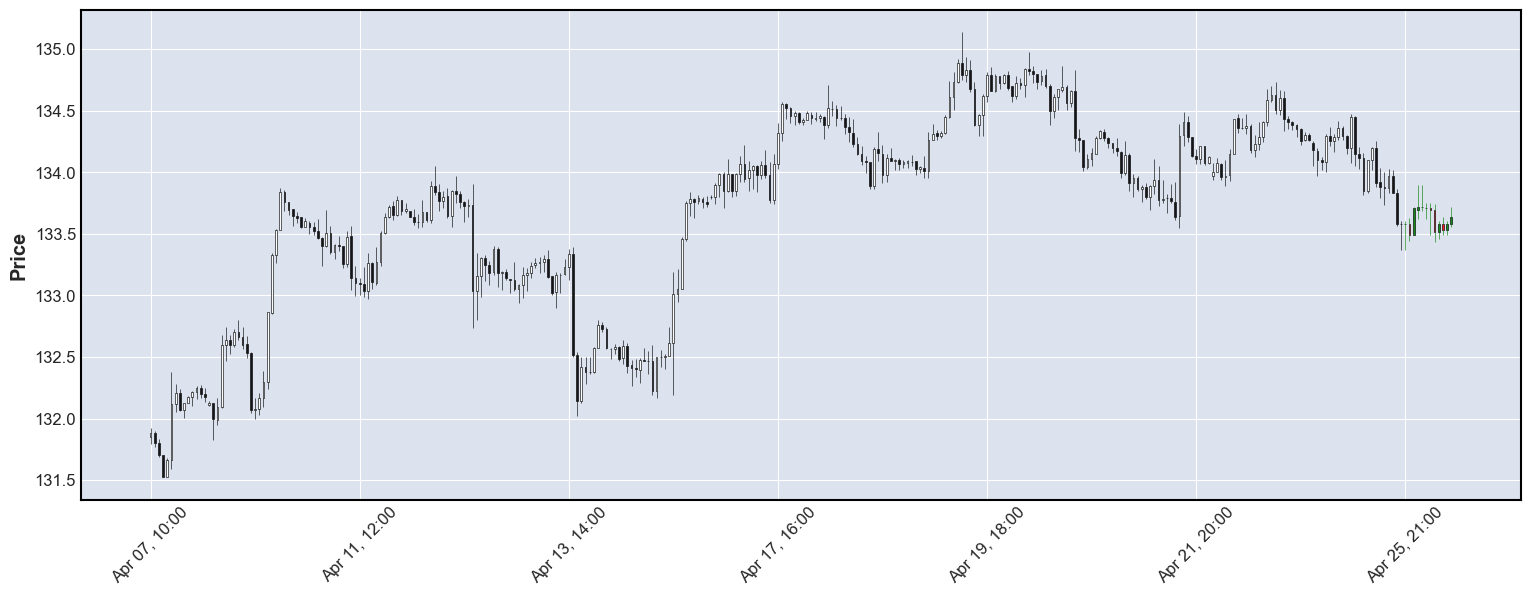

In [37]:

#creating a nan array to match both dataframes shape:
plot_ticks = 300
nan_array = np.zeros((plot_ticks, 5))
nan_array[:] = np.nan
pd.concat((pd.DataFrame(nan_array, columns=unseen_data.columns, index=data.index[-plot_ticks:]), unseen_data))

#plot styling
mc = mpl.make_marketcolors(up='green',down='red', edge='black', wick='green')
s  = mpl.make_mpf_style(marketcolors=mc)

fig, axlist = mpl.plot(data[['open','close','high','low']][-plot_ticks:], #plotting the last 100 values since 5000 ticks are too much data.  #data[['open','close','high','low']][-100:]
                       type='candle',
                       returnfig = True,**{'figsize':(20,7)})
mpl.plot(pd.concat((pd.DataFrame(nan_array, columns=unseen_data.columns, index=data.index[-plot_ticks:]), unseen_data))[['open','close','high','low']],
          type='candle',
          ax=axlist[0],
          style = s)


The data has a strong trend and seasonality so it will be usefull to perform a trend and seasonal decomposition to train deep learning models in the future.

### Decomposing time series data:

The decomposition of a time series is the process of extracting the three components and 
representing them as their models. The modeling of the decomposed components can be 
either additive or multiplicative. 

You have an additive model when the original time series can be reconstructed by adding 
all three components:

$ Y_t = T_t + S_t + R_t $

An additive decomposition model is reasonable when the seasonal variations do 
not change over time. 

On the other hand, if the time series can be reconstructed by 
multiplying all three components, you have a multiplicative model:

$ Y_t = T_t \cdot S_t \cdot R_t $

### Data preprocessing and feature engineering:

We will use the next features:
- Open, High, Low, and Close prices
- trend indicators:
    - Detrended prices oscilator (DPOIndicator)
    - Mass Index
    - TRIX indicator
    - Vortex Indicator
- volume indicators:
    - Chaikin money flow
    - Volume-price trend
    - Force Index


In [6]:
data['week_day'] = data.index.dayofweek
data['month_day'] = data.index.day
data['week_of_year'] = data.index.quarter
data['month'] = data.index.month
data['hour'] = data.index.hour

data['open_diff_1'] = data.open.diff(1)
data['high_diff_1'] = data.high.diff(1)
data['low_diff_1'] = data.low.diff(1)
data['close_diff_1'] = data.close.diff(1)


#Detrended price oscilator:
# data['DPOIndicator'] = ta.trend.DPOIndicator(data.close, window=21,fillna=True).dpo()
# unseen_data['DPOIndicator'] = ta.trend.DPOIndicator(unseen_data.close, window=21,fillna=True).dpo()

# #Mass_index oscilator
#data['mass_index'] = ta.trend.MassIndex(data.high, data.low, window_fast=21,fillna=True).mass_index()
# unseen_data['mass_index'] = ta.trend.MassIndex(unseen_data.high, unseen_data.low,fillna=True).mass_index()

# # TRIX_indicator:
# data['TRIX_indicator'] = ta.trend.TRIXIndicator(data.close, fillna=True).trix()
# unseen_data['TRIX_indicator'] = ta.trend.TRIXIndicator(unseen_data.close, fillna=True).trix()

#Vortex_indicator
# data['vortex_indicator_diff'] = ta.trend.VortexIndicator(data.high, data.low, data.close, fillna=True).vortex_indicator_diff()
# data['vortex_indicator_neg'] = ta.trend.VortexIndicator(data.high, data.low, data.close, fillna=True).vortex_indicator_neg()
# data['vortex_indicator_pos'] = ta.trend.VortexIndicator(data.high, data.low, data.close, fillna=True).vortex_indicator_pos()

# unseen_data['vortex_indicator_diff'] = ta.trend.VortexIndicator(unseen_data.high, unseen_data.low, unseen_data.close, fillna=True).vortex_indicator_diff()
# unseen_data['vortex_indicator_neg'] = ta.trend.VortexIndicator(unseen_data.high, unseen_data.low, unseen_data.close, fillna=True).vortex_indicator_neg()
# unseen_data['vortex_indicator_pos'] = ta.trend.VortexIndicator(unseen_data.high, unseen_data.low, unseen_data.close, fillna=True).vortex_indicator_pos()

# #Chaikin money flow
#data['chaikin_money_flux'] = ta.volume.ChaikinMoneyFlowIndicator(data.high, data.low, data.close, data.tick_volume, fillna=True).chaikin_money_flow()
# unseen_data['chaikin_money_flux'] = ta.volume.ChaikinMoneyFlowIndicator(unseen_data.high, unseen_data.low, unseen_data.close, unseen_data.tick_volume, fillna=True).chaikin_money_flow()

# #Volume price trend:
#data['volume_price_trend'] = ta.volume.VolumePriceTrendIndicator(data.close, data.tick_volume, fillna=True).volume_price_trend()
# unseen_data['volume_price_trend'] = ta.volume.VolumePriceTrendIndicator(unseen_data.close, unseen_data.tick_volume, fillna=True).volume_price_trend()

# #force index 
#data['force_index'] = ta.volume.ForceIndexIndicator(data.close, data.tick_volume, fillna=True).force_index()
# unseen_data['force_index'] = ta.volume.ForceIndexIndicator(unseen_data.close, unseen_data.tick_volume, fillna=True).force_index()

# data['open_shifted_1'] = data.open.shift(1)
# data['open_shifted_2'] = data.open.shift(2)
# data['open_shifted_3'] = data.open.shift(3)

# data['high_shifted_1'] = data.high.shift(1)
# data['high_shifted_2'] = data.high.shift(2)
# data['high_shifted_3'] = data.high.shift(3)

# data['low_shifted_1'] = data.low.shift(1)
# data['low_shifted_2'] = data.low.shift(2)
# data['low_shifted_3'] = data.low.shift(3)

# data['close_shifted_1'] = data.close.shift(1)
# data['close_shifted_2'] = data.close.shift(2)
# data['close_shifted_3'] = data.close.shift(3)
# data['close_diff_1'] = data.close - data.close_shifted_1
# data['close_diff_2'] = data.close - data.close_shifted_2
# data['close_diff_3'] = data.close - data.close_shifted_3

# unseen_data['close_shifted_1'] = unseen_data.close.shift(1)
# unseen_data['close_shifted_2'] = unseen_data.close.shift(2)
# unseen_data['close_shifted_3'] = unseen_data.close.shift(3)
# unseen_data['close_diff_1'] = unseen_data.close - unseen_data.close_shifted_1
# unseen_data['close_diff_2'] = unseen_data.close - unseen_data.close_shifted_2
# unseen_data['close_diff_3'] = unseen_data.close - unseen_data.close_shifted_3


# unseen_data['week_day'] = unseen_data.index.weekday
# unseen_data['month_day'] = unseen_data.index.day
# unseen_data['week_of_year'] = unseen_data.index.quarter
# unseen_data['month'] = unseen_data.index.month
# unseen_data['hour'] = unseen_data.index.hour
# unseen_data['open_close_diff'] = unseen_data.close - unseen_data.open
# unseen_data['high_low_diff'] = unseen_data.high - unseen_data.low


#data.drop(columns='tick_volume',inplace=True)
#unseen_data.drop(columns='tick_volume',inplace=True)

# data.drop(index=data.index[0],inplace=True)
# unseen_data.drop(index=unseen_data.index[0],inplace=True)





print('data shape: ', data.shape)
print('unseen data shape: ', unseen_data.shape)

data shape:  (5760, 14)
unseen data shape:  (12, 5)


In [7]:
data.dropna(inplace=True)
unseen_data.dropna(inplace=True)

In [8]:
data.isna().sum()

open            0
high            0
low             0
close           0
tick_volume     0
week_day        0
month_day       0
week_of_year    0
month           0
hour            0
open_diff_1     0
high_diff_1     0
low_diff_1      0
close_diff_1    0
dtype: int64

In [9]:
# period = 24*5
# model_type = 'multiplicative'
# new_data = {

#     'open_trend': seasonal_decompose(data.open, model=model_type, period=period, two_sided=False).trend.dropna(),
#     'open_seasonal': seasonal_decompose(data.open, model=model_type, period=period, two_sided=False).seasonal.dropna(),
#     'open_residual': seasonal_decompose(data.open, model=model_type, period=period, two_sided=False).resid.dropna(),

#     'high_trend': seasonal_decompose(data.high, model=model_type, period=period, two_sided=False).trend.dropna(),
#     'high_seasonal': seasonal_decompose(data.high, model=model_type, period=period, two_sided=False).seasonal.dropna(),
#     'high_residual': seasonal_decompose(data.high, model=model_type, period=period, two_sided=False).resid.dropna(),

#     'low_trend': seasonal_decompose(data.low, model=model_type, period=period, two_sided=False).trend.dropna(),
#     'low_seasonal': seasonal_decompose(data.low, model=model_type, period=period, two_sided=False).seasonal.dropna(),
#     'low_residual': seasonal_decompose(data.low, model=model_type, period=period, two_sided=False).resid.dropna(),

#     'close_trend': seasonal_decompose(data.close, model=model_type, period=period, two_sided=False).trend.dropna(),
#     'close_seasonal': seasonal_decompose(data.close, model=model_type, period=period, two_sided=False).seasonal.dropna(),
#     'close_residual': seasonal_decompose(data.close, model=model_type, period=period, two_sided=False).resid.dropna(),

# }

# data = pd.concat((data, pd.DataFrame(new_data, index=data.index)[period:]))
# data.head()

In [10]:

data.dtypes

open            float64
high            float64
low             float64
close           float64
tick_volume      uint64
week_day          int32
month_day         int32
week_of_year      int32
month             int32
hour              int32
open_diff_1     float64
high_diff_1     float64
low_diff_1      float64
close_diff_1    float64
dtype: object

### zero mean scaling the training dataframe:

In [11]:
data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
data = (data - data_mean) / data_std

In [12]:
data.isna().sum()

open            0
high            0
low             0
close           0
tick_volume     0
week_day        0
month_day       0
week_of_year    0
month           0
hour            0
open_diff_1     0
high_diff_1     0
low_diff_1      0
close_diff_1    0
dtype: int64

<Axes: ylabel='Frequency'>

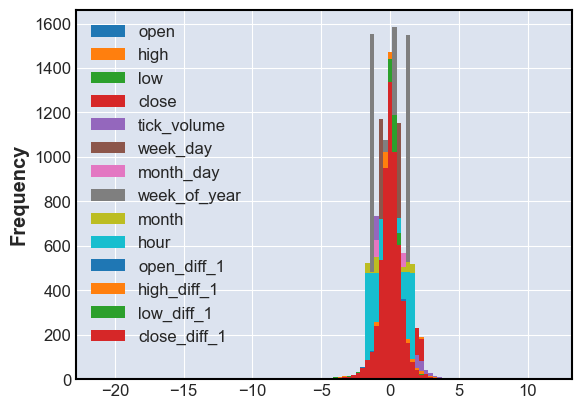

In [13]:
data.plot(kind='hist', bins=100)

### Splitting the main dataframe into training and validation datasets:

In [14]:
train_size = int(len(data)*0.80)

train_data, test_data = data[:train_size], data[train_size:]

print('total training instances: ',train_data.shape) 
print('total test instances: ',test_data.shape)

total training instances:  (4607, 14)
total test instances:  (1152, 14)


## Baseline model: Building a multi-varate time series model using statistical methods.

In [14]:
import pandas as pd
import numpy as np
import scipy 
import sklearn
import matplotlib.pyplot as plt
import warnings

#satistical package
import statsmodels as sm
from statsmodels.tsa.api import (kpss, adfuller, 
                                 seasonal_decompose, STL)
#metrics
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
#autocorrelation testing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#misc utils
from itertools import product
from pathlib import Path

warnings.filterwarnings('ignore')


#Plot config:
plt.rcParams["figure.figsize"] = [12, 7]  

IndexError: index 4 is out of bounds for axis 0 with size 4

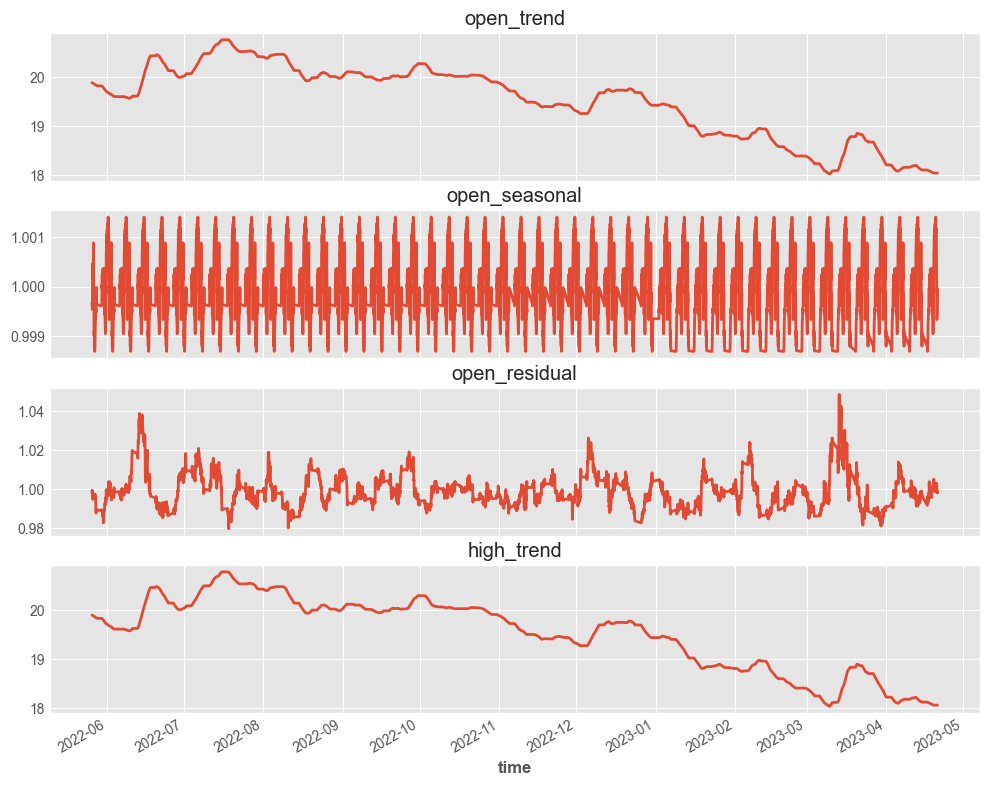

In [702]:
fig_1, ax_1 = plt.subplots(4, 1, figsize = (12,10), sharex=True)
for i in range(data.shape[1]):
    data[data.columns[i]].plot(ax=ax_1[i], title=data.columns[i])

as we knew already, all three variables (OHLC prices) has a strong trend and seasonality but lets conduct an augmented Dickey-Fuller Test to prove that prices are not stationary

In [32]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [113]:
for col in data.columns:
    print(f'variable {col} is: ')
    check_stationarity(data[col])

variable open is: 
'Non-Stationary	 p-value:0.5460700009638473 	 lags:0
variable high is: 
'Non-Stationary	 p-value:0.5332458044976325 	 lags:1
variable low is: 
'Non-Stationary	 p-value:0.5652436271985953 	 lags:10
variable close is: 
'Non-Stationary	 p-value:0.5470111505628082 	 lags:0


### Plotting the Auto Correlation Function (ACF) and the Partial Auto Correlation Function (PACF)

We will use the PACF plot to estimate the Autoregressive order and the ACF to estimate the Moving Average order. Both the ACF and PACF plots show values that ranges florm -1 to 1 on the y-axis while the horizontal axis indicates de size of the lag, hence, a significant lag is any lag that goes outside the shaded confidence interval.

To plot the ACF and PACF, we need to first apply a seasonal differencing to remove the seasonal effect. Since the observations are taken hourly, the seasonal effects might be observed daily, weekly or even monthly, so lets diff the data and apply a ADF test to see if they become stationary.

### 

'Stationary	 p-value:4.923192838235027e-21 	 lags:32
'Stationary	 p-value:1.857524598201816e-22 	 lags:32
'Stationary	 p-value:2.4470327069039278e-15 	 lags:24
'Stationary	 p-value:5.032479972489186e-06 	 lags:21
'Non-Stationary	 p-value:0.20346697069692132 	 lags:8


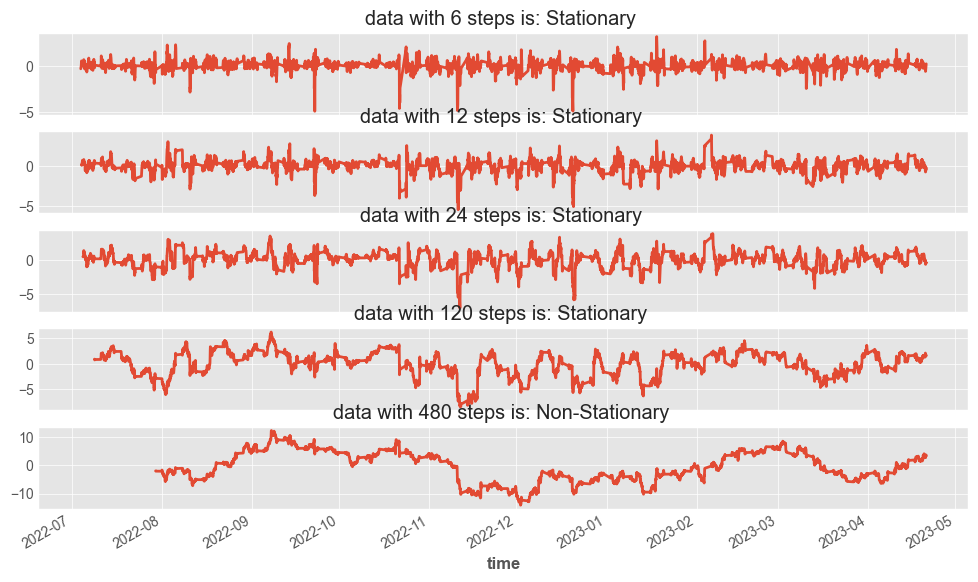

In [137]:
#as the four prices are highly correlated we will experiment with just the close price:

n_difference = [6, 12, 24, 24*5, 24*20]

fig, ax = plt.subplots(len(n_difference), 1, sharex=True)
for i, n in enumerate(n_difference):
    data.close.diff(n).dropna().plot(title=f'data with {n} steps is: {check_stationarity(data.close.diff(n).dropna())[0]} ', ax=ax[i])
    

as we can see in the plot above, data becomes stationary with a 24 and 120 diffenrencing steps, so lets use the 24 steps to plot the ACF and PACF for OHLC prices:

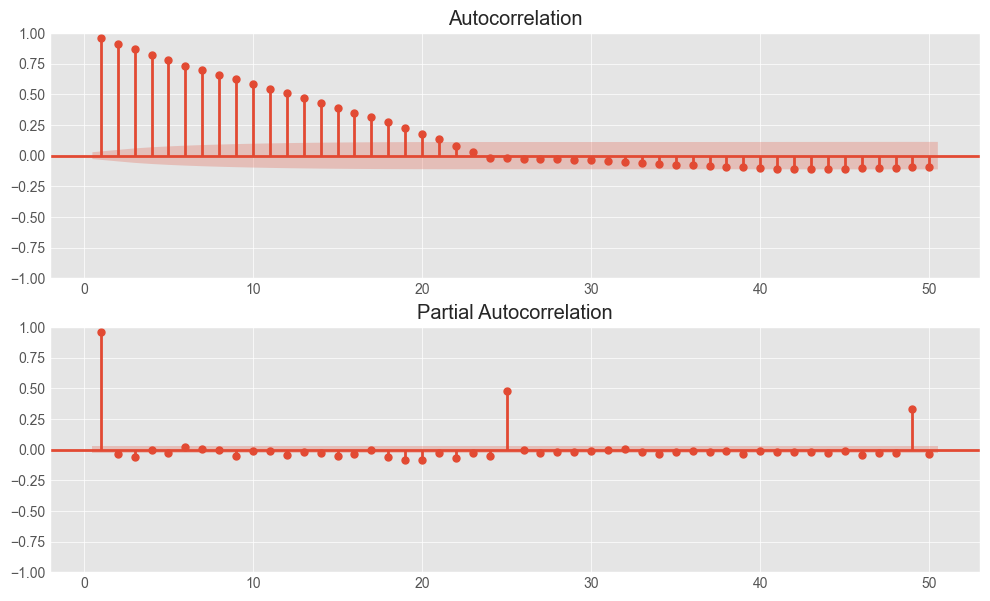

In [164]:
n_steps = 24

fig, ax = plt.subplots(2,1)
plot_acf(data[col].diff(n_steps).dropna(), zero=False, ax=ax[0], lags=50, alpha=0.05);
plot_pacf(data[col].diff(n_steps).dropna(), zero=False, ax=ax[1], lags=50, alpha=0.05);

We notice a gradual decay after the lag 24 in the ACF plot which indicates a strong seasonal order in the auroregressive process and at the same time the PACF plot shows aa gradual decay at lags 1, 24 and 28 which indicates an MA model to, so the SARIMA Model could be an ARIMA(0,1,1)(0,1,1,24).

### Building a Seasonal Autoregressive Integrated Moving Average (SARIMA) model:

for practicity we will use the auto_arima class from the pmdarima package in search of the best model to forecast each variable.

In [166]:
import pmdarima as pm


In [284]:
close_model = pm.auto_arima(y=data.close[-24*13:],
                            seasonal=True,
                            m=24,
                            test='adf', #change default hypotesis test to augmented dickey-fuller test
                            stepwise=True, trace=True)
close_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=-256.658, Time=1.22 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-250.798, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=-259.245, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-261.196, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-252.383, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=-251.088, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=-259.282, Time=0.40 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=-259.497, Time=1.20 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=-259.175, Time=0.24 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=-260.676, Time=0.16 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=-259.267, Time=0.38 sec
 ARIMA(0,1,2)(0,0,1)[24] intercept   : AIC=-259.299, Time=0.28 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=-261.257, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[24]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  312
Model:             SARIMAX(1, 1, 0)x(0, 0, [1], 24)   Log Likelihood                 134.543
Date:                              Sun, 23 Apr 2023   AIC                           -263.086
Time:                                      00:33:01   BIC                           -251.866
Sample:                                           0   HQIC                          -258.601
                                              - 312                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0916      0.051      1.792      0.073      -0.009       0.192
ma.S.L24       0.2199      0.038      5.717      0.000       0.145       0.295
sigma2         0.0246      0.001     19.488      0.000       0.022       0.027
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               315.84
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.66
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [288]:
close_predictions = close_model.predict(24)
close_predictions

312    134.217936
313    134.242845
314    134.240153
315    134.268518
316    134.254087
317    134.246775
318    134.233242
319    134.242014
320    134.216755
321    134.163364
322    134.181768
323    134.187466
324    134.195507
325    134.165304
326    134.193320
327    134.124832
328    134.116723
329    134.059653
330    134.065988
331    134.083234
332    134.104322
333    134.119176
334    134.103565
335    134.099587
dtype: float64

In [289]:
close_mape = list()

for i in range(unseen_data.shape[0]):
    mape = mean_absolute_percentage_error([unseen_data.close[i]], [close_predictions.values[i]])
    close_mape.append(mape)

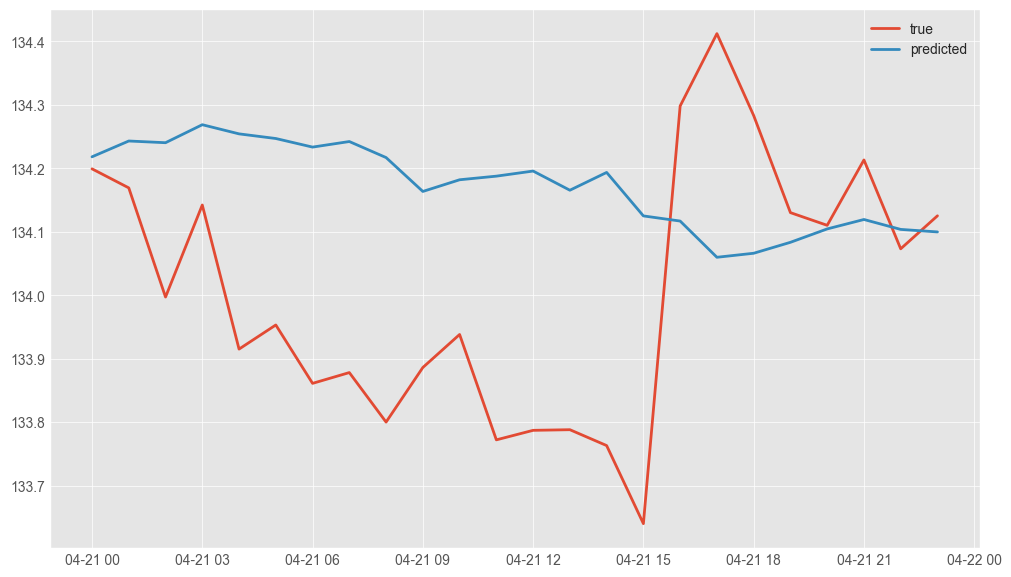

In [290]:
plt.plot(unseen_data.index, unseen_data.close, label='true')
plt.plot(unseen_data.index, close_predictions, label='predicted')
plt.legend()

# Deep Learning Approach

## Pytorch Datasets

In [15]:
class PriceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, index):
        sequence, target = self.sequences[index]

        return dict(
            sequence = torch.tensor(sequence.values.astype('float32')),
            target = torch.tensor(target.values.astype('float32'))
        )
    

In [16]:
def create_sequences_(input_data: pd.DataFrame, target_column, sequence_lenght, _future=0):
    sequences = list()

    data_size = len(input_data)

    for i in tqdm(range(data_size - sequence_lenght)):
        sequence = input_data[i:i+sequence_lenght]

        target_position = i + sequence_lenght
        target = input_data.iloc[target_position][target_column]
        if _future > 0:
            target = input_data.iloc[target_position:target_position+_future][target_column]

        sequences.append((sequence, target))
    return sequences

In [17]:
SEQUENCE_LENGHT = 24*4
train_sequences = create_sequences_(train_data, data.columns, SEQUENCE_LENGHT, _future=future)
test_sequences = create_sequences_(test_data, data.columns, SEQUENCE_LENGHT, _future=future)
print('total training sequences: ',len(train_sequences))
print('total test squences: ',len(test_sequences))

100%|██████████| 1056/1056 [00:00<00:00, 1903.24it/s]

total training sequences:  4511
total test squences:  1056


In [18]:
train_dataset = PriceDataset(train_sequences)
test_dataset = PriceDataset(test_sequences)

print('train_dataset lenght: ',len(train_dataset))
print('test_dataset lenght: ',len(test_dataset))

train_dataset lenght:  4511
test_dataset lenght:  1056


In [19]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,drop_last=True )

In [20]:
for i , item in enumerate(test_loader):
    print(item['sequence'].shape)
    print(item['target'].shape)
    


torch.Size([64, 96, 14])
torch.Size([64, 12, 14])
torch.Size([64, 96, 14])
torch.Size([64, 12, 14])
torch.Size([64, 96, 14])
torch.Size([64, 12, 14])
torch.Size([64, 96, 14])
torch.Size([64, 12, 14])
torch.Size([64, 96, 14])
torch.Size([64, 12, 14])
torch.Size([64, 96, 14])
torch.Size([64, 12, 14])
torch.Size([64, 96, 14])
torch.Size([64, 12, 14])
torch.Size([64, 96, 14])
torch.Size([64, 12, 14])
torch.Size([64, 96, 14])
torch.Size([64, 12, 14])
torch.Size([64, 96, 14])
torch.Size([64, 12, 14])
torch.Size([64, 96, 14])
torch.Size([64, 12, 14])
torch.Size([64, 96, 14])
torch.Size([64, 12, 14])
torch.Size([64, 96, 14])
torch.Size([64, 12, 14])
torch.Size([64, 96, 14])
torch.Size([64, 12, 14])
torch.Size([64, 96, 14])
torch.Size([64, 12, 14])
torch.Size([64, 96, 14])
torch.Size([64, 12, 14])


## Network Architecture

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, future=0,num_layers=1, dropout = 0):
        super(LSTM, self).__init__()
        torch.manual_seed(2023)
        self.future = future
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x, validation_target=None):
        self.lstm.flatten_parameters()
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Decode the hidden state of the last time step
        if self.future>0: 
            out = self.output_layer(out[:,-self.future:,:])
        else: 
            out = self.output_layer(out[:, -1, :])



        if validation_target != None:
            #print(out.shape, validation_target.shape)
            loss = nn.MSELoss()(out, validation_target)
            
            if self.future > 0: loss = nn.MSELoss()(out, validation_target[:, :,:out.shape[-1]])

            return out, loss

        return out

## validation and training loop

In [22]:
def model_evaluation(model, test_dataloader):
    validation_loss = 0.0
    model.eval()
    output_shape = model.get_parameter('output_layer.bias').shape[0]
    with torch.no_grad():
        for item in test_dataloader:

            sequence, target = item['sequence'], item['target']
            if output_shape != target.shape[-1]:
                output, loss = model(sequence, target[:, :,:output_shape])
            else: 
                output, loss = model(sequence, target)

            validation_loss +=loss.item()
        return validation_loss/len(test_dataloader)

In [23]:
def model_training(model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs, scheduler=None, early_stop = None):

     epoch_loss = list()
     valid_epoch_loss = list()

     for epoch in range(n_epochs):
          train_loss = 0.0
          model.train() #initializing the model training
          for data in tqdm(train_dataloader):

               sequence, target = data['sequence'], data['target']
               #images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE) #for cuda training
               optimizer.zero_grad()
               #print(sequence.shape, target.shape)
               #Forward pass:
               output_data = model(sequence)
               #print(output_data.shape, target.shape)
               #print(output_data.shape, target.shape)
               #calculate loss:
               loss = loss_fn(output_data, target[:,:, :output_data.shape[-1]])

               #backprogate
               loss.backward()

               #update weigths
               optimizer.step()


               train_loss += loss.item()
          
          validation_loss = model_evaluation(model, test_dataloader)
          #learning rate scheduler:

          scheduler.step(validation_loss)


          #return train_loss/len(train_dataloader)
          print("Epoch: {} - Loss:{:.4f} - val_loss: {:.4f}".format(epoch+1,
                                                                    train_loss/len(train_dataloader), 
                                                                    validation_loss))
          epoch_loss.extend([train_loss/len(train_dataloader)])
          valid_epoch_loss.extend([validation_loss])
     #Plot the Loss curve and ROC Curve
     plt.figure(figsize=(9,4))
     plt.plot(epoch_loss,label='train_loss')
     plt.title('Loss across epochs')
     plt.ylabel('Loss')
     plt.xlabel('Epochs')
     plt.plot(valid_epoch_loss, label='valid_loss')
     plt.legend()


     return epoch_loss, valid_epoch_loss


## Model Fiting

In [24]:
model = LSTM(input_size = data.shape[1], hidden_size = 128, output_size = 4, future = future, num_layers=2, dropout=0.2)

100%|██████████| 70/70 [00:17<00:00,  4.00it/s]


Epoch: 1 - Loss:0.3664 - val_loss: 0.3877


100%|██████████| 70/70 [00:16<00:00,  4.20it/s]


Epoch: 2 - Loss:1.0725 - val_loss: 0.3604


100%|██████████| 70/70 [00:07<00:00,  9.60it/s]


Epoch: 3 - Loss:0.8335 - val_loss: 0.3689


100%|██████████| 70/70 [00:08<00:00,  8.63it/s]


Epoch: 4 - Loss:0.5624 - val_loss: 0.2728


100%|██████████| 70/70 [00:11<00:00,  5.90it/s]


Epoch: 5 - Loss:0.3422 - val_loss: 0.1448


100%|██████████| 70/70 [00:10<00:00,  6.87it/s]


Epoch: 6 - Loss:0.2295 - val_loss: 0.0354


100%|██████████| 70/70 [00:09<00:00,  7.15it/s]


Epoch: 7 - Loss:0.0762 - val_loss: 0.0286


100%|██████████| 70/70 [00:09<00:00,  7.20it/s]


Epoch: 8 - Loss:0.0623 - val_loss: 0.0345


100%|██████████| 70/70 [00:14<00:00,  4.89it/s]


Epoch: 9 - Loss:0.0469 - val_loss: 0.0246


100%|██████████| 70/70 [00:13<00:00,  5.04it/s]


Epoch: 10 - Loss:0.0658 - val_loss: 0.0197


100%|██████████| 70/70 [00:19<00:00,  3.52it/s]


Epoch: 11 - Loss:0.0730 - val_loss: 0.0197


100%|██████████| 70/70 [00:16<00:00,  4.16it/s]


Epoch: 12 - Loss:0.0498 - val_loss: 0.0236


100%|██████████| 70/70 [00:12<00:00,  5.48it/s]


Epoch: 13 - Loss:0.0407 - val_loss: 0.0393


100%|██████████| 70/70 [00:15<00:00,  4.61it/s]


Epoch: 14 - Loss:0.0308 - val_loss: 0.0203


100%|██████████| 70/70 [00:14<00:00,  4.71it/s]


Epoch: 15 - Loss:0.0244 - val_loss: 0.0182


100%|██████████| 70/70 [00:13<00:00,  5.13it/s]


Epoch: 16 - Loss:0.0241 - val_loss: 0.0177


100%|██████████| 70/70 [00:15<00:00,  4.60it/s]


Epoch: 17 - Loss:0.0237 - val_loss: 0.0174


100%|██████████| 70/70 [00:12<00:00,  5.61it/s]


Epoch: 18 - Loss:0.0237 - val_loss: 0.0171


100%|██████████| 70/70 [00:15<00:00,  4.58it/s]


Epoch: 19 - Loss:0.0235 - val_loss: 0.0168


100%|██████████| 70/70 [00:13<00:00,  5.27it/s]


Epoch: 20 - Loss:0.0236 - val_loss: 0.0166


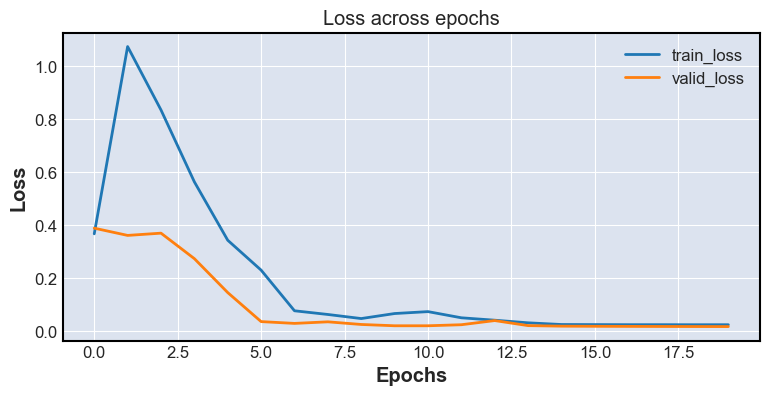

In [25]:
adam_optim = torch.optim.Adam(model.parameters(),lr=0.001)
SGD_optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_function = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam_optim,'min', 
                                                       factor=0.1, 
                                                       patience = 2, threshold=1e-3)

NUM_EPOCHS=20

adam_loss = model_training(model = model, 
                           optimizer = adam_optim, 
                           loss_fn = loss_function, 
                           train_dataloader = train_loader,
                           test_dataloader=test_loader,
                           n_epochs = NUM_EPOCHS, 
                           scheduler=scheduler)

## Model Testing on unseen data:

In [26]:
predictions = model(test_dataset[-1]['sequence'].unsqueeze(0))
predictions

tensor([[[-0.4638, -0.4660, -0.4514, -0.4660],
         [-0.4219, -0.4252, -0.4132, -0.4261],
         [-0.4213, -0.4195, -0.4073, -0.4210],
         [-0.4412, -0.4443, -0.4309, -0.4472],
         [-0.4889, -0.4905, -0.4802, -0.4960],
         [-0.4830, -0.4886, -0.4800, -0.4960],
         [-0.4651, -0.4684, -0.4582, -0.4758],
         [-0.4904, -0.4910, -0.4820, -0.4991],
         [-0.5111, -0.5163, -0.5076, -0.5245],
         [-0.4990, -0.5038, -0.4962, -0.5125],
         [-0.4887, -0.4947, -0.4857, -0.5041],
         [-0.5116, -0.5166, -0.5074, -0.5270]]], grad_fn=<ViewBackward0>)

In [27]:
predictions = pd.DataFrame(predictions.detach().squeeze(0).numpy(), index=unseen_data.index,columns=unseen_data.columns[:4])*data_std[:4] + data_mean[:4]
predictions

,open,high,low,close
time,,,,
2023-04-25 20:00:00,133.962093,134.088033,133.886821,133.952836
2023-04-25 21:00:00,134.191610,134.311523,134.096222,134.171556
2023-04-25 22:00:00,134.195067,134.342783,134.128876,134.199823
2023-04-25 23:00:00,134.086253,134.207272,133.999393,134.055997
2023-04-26 00:00:00,133.824530,133.953589,133.729240,133.788379
2023-04-26 01:00:00,133.856715,133.964140,133.730298,133.788290
2023-04-26 02:00:00,133.954772,134.075155,133.849608,133.899011
2023-04-26 03:00:00,133.815961,133.951276,133.719367,133.771349
2023-04-26 04:00:00,133.702854,133.812608,133.578853,133.631902


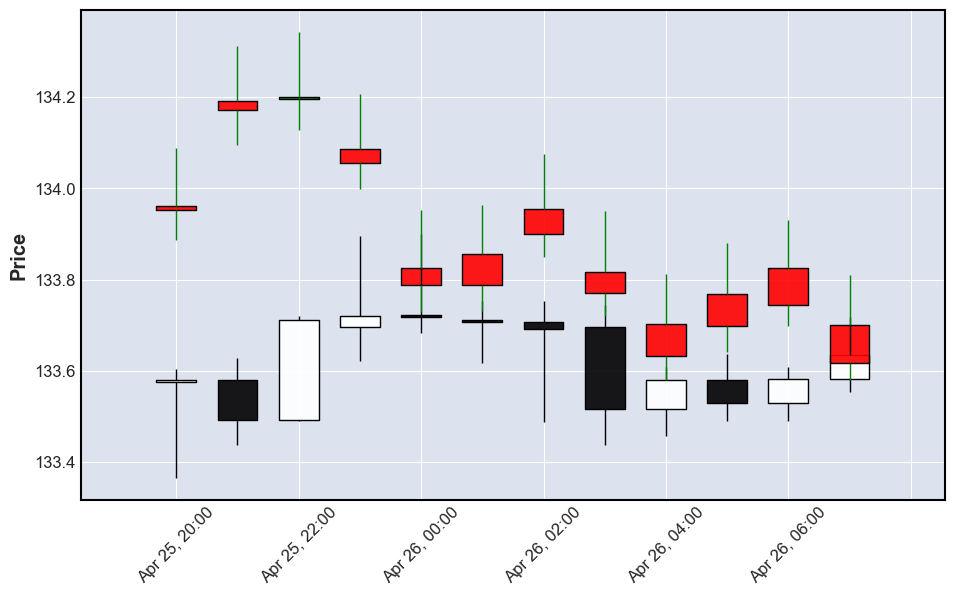

In [38]:
fig, axlist = mpl.plot(unseen_data[['open','high','low','close']], #plotting the last 100 values since 5000 ticks are too much data.data[['open','close','high','low']][-100:]
                       type='candle',
                       returnfig = True, **{'figsize': (12,7)})
mpl.plot(predictions[['open','high','low','close']],
          type='candle',
          ax=axlist[0],
          style = s)

In [114]:
predictions = np.empty(shape=(1,4))
labels = np.empty(shape=(1,4))
for item in unseen_dataset:
    sequence = item['sequence']
    label = item['target']
    output = model(sequence.unsqueeze(0)).squeeze(0)
    print(output.shape)

    #print(output.detach().numpy().shape, label.unsqueeze(0).shape)
    predictions = np.concatenate((predictions, output[:4].detach().numpy()), axis=0)
    labels = np.concatenate((labels, label[:4].unsqueeze(0).numpy()), axis=0)

print(predictions.shape)
print(labels.shape)

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
(21, 4)
(21, 4)


In [115]:
labels_df = pd.DataFrame(labels, columns = unseen_data.columns[:4], index=unseen_data.index[pred_sequence_lenght-1:])*unseen_std + unseen_mean
predictions_df = pd.DataFrame(predictions, columns = unseen_data.columns[:4], index=unseen_data.index[pred_sequence_lenght-1:])*unseen_std + unseen_mean


implement the RMSE metric to measure the models performance against future implementations of CNN-LSTM and ConvLSTM models

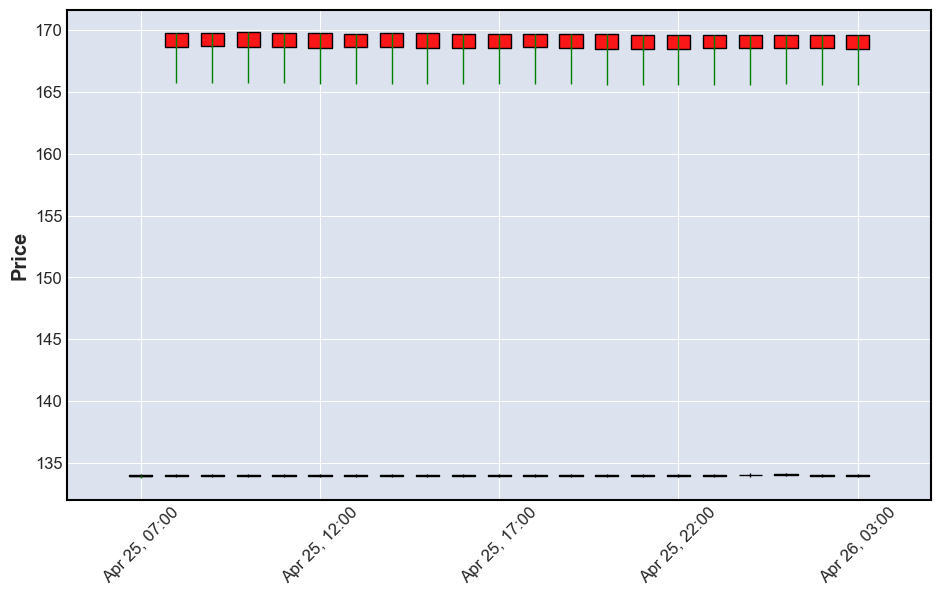

In [116]:
mc = mpl.make_marketcolors(up='green',down='red', edge='black', wick='green', )
s  = mpl.make_mpf_style(marketcolors=mc)

fig, axlist = mpl.plot(predictions_df[['open','high','low','close']], #plotting the last 100 values since 5000 ticks are too much data.data[['open','close','high','low']][-100:]
                       type='candle',
                       returnfig = True, **{'figsize': (12,7)})
mpl.plot(labels_df[['open','high','low','close']],
          type='candle',
          ax=axlist[0],
          style = s)